# Trust in the Machine: How Contextual Factors and Personality Traits Shape Algorithm Aversion and Collaboration  - Notebook 3 / 3.

## Uplift Random Forest Implementation and Causal Inference Analysis

**Authors:**<br>
Vinicius Ferraz - Alfred-Weber Institute for Economics, University of Heidelberg <br>
Christiane Schwieren - Alfred-Weber Institute for Economics, University of Heidelberg <br>
Leon Houf - Alfred-Weber Institute for Economics, University of Heidelberg <br>
Thomas Pitz - Faculty of Society and Economics, Rhine-Waal University<br>
Jörn Sickmann -  Faculty of Society and Economics, Rhine-Waal University

This Jupyter Notebook contains the reproduction of the uplift random forest model implemented in the paper. In case of any questions, plese contact Vinicius Ferraz (visferraz@gmail.com). 

In [6]:
import multiprocessing as mp
import optuna
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import Image
from sklearn.model_selection import train_test_split, StratifiedKFold, GroupKFold
from causalml.metrics import qini_score, plot_gain, auuc_score, plot_qini

from causalml.inference.tree import (
    UpliftRandomForestClassifier,
    uplift_tree_string,
    uplift_tree_plot,
)

from causalml.dataset import make_uplift_classification, synthetic_data

In [2]:
sns.set_theme(style="white", palette=None)

#### Data Parsing

In [8]:
# reading pre-processed merged dataset (generated from the Data Analysis file)
df_merged = pd.read_csv('data/df_merged_processed.csv')
df_merged.fillna(0, inplace=True)

In [9]:
# creating a smaller dataframe with only variables of interest

df = df_merged[['treat_string','treatment','delegation_bin', 'male', 'female', 'stem', 'business_econ',
                'age', 'extraversion', 'agreeableness', 'conscientiousness', 'neuroticism', 'openness', 
                'internal_loc', 'external_loc', 'trust', 'perception', 'participant_code']]

In [10]:
# defining the model covariates (X)
covariates = ['female', 'stem', 'business_econ', 'age', 'extraversion', 'agreeableness', 'conscientiousness', 
              'neuroticism', 'openness', 'internal_loc', 'external_loc', 'trust', 'perception']

In [12]:
# Data split for training and predictions
df_train, df_test = train_test_split(df, test_size=0.2, random_state=111)

In [15]:
efunc = 'Chi'
norm = True

### Logistic Regression Prediction Model

Function for hyperparameter optimization using Optiuna and the AUUC as performance benchmarks. 

<font color='red'>IMPORTANT:</font> The computation of the AUUC has stochastic mechanisms in place; therefore, it can generate improper AUUC scores due to the computation of cumulative gains, which can mislead the optimization model. Here, practitioners must observe the tuning output and look for a set of parameters with reasonable scores (that is, close to 1, higher, or lower). Optimizing causal inference models is more challenging than regular machine learning models since the counterfactual information cannot be measured to assess the quality of the predictions directly.

In [16]:
# optimization and model fit with cross validation on a participant level


# Optimization of hyperparameters
def optimize_uplift_rf_CV(df_train, df_test, covariates, dep, ntrials, control_name, treat_col, participant_col):

    def objective(trial):
        # defining parameter search ranges
        n_estimators = trial.suggest_int('n_estimators', 50, 1000, step=50)
        max_depth = trial.suggest_int('max_depth', 2, 25, step=2)
        max_features = trial.suggest_int('max_features', 3, len(covariates), step=1)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 10, 50, step=5)
        min_samples_treatment = trial.suggest_int('min_samples_treatment', 10, 100, step=5)
        n_reg = trial.suggest_int('n_reg', 2, 20, step = 2)
        evaluationFunction = trial.suggest_categorical('evaluationFunction', ['KL', 'ED', 'Chi', 'CTS'])
        
        # fit model
        uplift_model = UpliftRandomForestClassifier(n_estimators=n_estimators, 
                                                    max_features=max_features, 
                                                    max_depth=max_depth, 
                                                    min_samples_leaf=min_samples_leaf, 
                                                    min_samples_treatment=min_samples_treatment,
                                                    n_reg=n_reg, 
                                                    control_name=control_name,
                                                    n_jobs=-1, 
                                                    evaluationFunction = evaluationFunction, 
                                                    normalization = norm,
                                                    random_state = 42)
        # group-cross validations
        gkf = GroupKFold(n_splits=5)
        auuc_scores = []

        for train_index, test_index in gkf.split(df_train, groups=df_train[participant_col]): # participant level
            X_train, X_test = df_train[covariates].values[train_index], df_train[covariates].values[test_index]
            treatment_train = df_train[treat_col].values[train_index]
            treatment_test = df_train[treat_col].values[test_index]
            y_train, y_test = df_train[dep].values[train_index], df_train[dep].values[test_index]

            uplift_model.fit(X=X_train, 
                             treatment=treatment_train, 
                             y=y_train)

            y_pred = uplift_model.predict(X_test)

            result = pd.DataFrame(y_pred, columns=uplift_model.classes_[1:])
            
            # synthetic control group
            best_treatment = np.where((result < 0).all(axis=1),
                                      'control',
                                      result.idxmax(axis=1))

            actual_is_best = np.where(treatment_test == best_treatment, 1, 0)
            actual_is_control = np.where(treatment_test == control_name, 1, 0)

            synthetic = (actual_is_best == 1) | (actual_is_control == 1)
            synth = result[synthetic]
            
            # compuing AUUC scores for each fold
            auuc_metrics = (synth.assign(is_treated=1 - actual_is_control[synthetic],
                                         delegation_bin=y_test[synthetic],
                                         uplift_tree=synth.max(axis=1))
                            .drop(columns=list(uplift_model.classes_[1:])))

            auuc = auuc_score(auuc_metrics, outcome_col=dep, treatment_col='is_treated')
            auuc_scores.append(auuc[0])

        return np.mean(auuc_scores)

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials = ntrials, n_jobs = -1) # -1 for multithreading
    urf_best_params = study.best_params
    return urf_best_params


Model fitting and performance metrics calculation functions

In [ ]:
def fit_uplift_rf_CV(df_train, df_test, covariates, dep, control_name, treat_col, urf_best_params, participant_col):
    
    uplift_model = UpliftRandomForestClassifier(n_estimators=urf_best_params['n_estimators'], 
                                                max_features=urf_best_params['max_features'], 
                                                max_depth=urf_best_params['max_depth'], 
                                                min_samples_leaf=urf_best_params['min_samples_leaf'], 
                                                min_samples_treatment=urf_best_params['min_samples_treatment'],
                                                n_reg=urf_best_params['n_reg'], 
                                                control_name=control_name,
                                                n_jobs=-1,
                                                evaluationFunction = urf_best_params['evaluationFunction'], 
                                                normalization = norm)

    gkf = GroupKFold(n_splits=5)
    auuc_scores = []

    for train_index, test_index in gkf.split(df_train, groups=df_train[participant_col]):
        X_train, X_test = df_train[covariates].values[train_index], df_train[covariates].values[test_index]
        treatment_train = df_train[treat_col].values[train_index]
        treatment_test = df_train[treat_col].values[test_index]
        y_train, y_test = df_train[dep].values[train_index], df_train[dep].values[test_index]

        uplift_model.fit(X=X_train, 
                         treatment=treatment_train, 
                         y=y_train)

        y_pred = uplift_model.predict(X_test)

        result = pd.DataFrame(y_pred, columns=uplift_model.classes_[1:])

        best_treatment = np.where((result < 0).all(axis=1),
                                  'control',
                                  result.idxmax(axis=1))

        actual_is_best = np.where(treatment_test == best_treatment, 1, 0)
        actual_is_control = np.where(treatment_test == control_name, 1, 0)

        synthetic = (actual_is_best == 1) | (actual_is_control == 1)
        synth = result[synthetic]

        auuc_metrics = (synth.assign(is_treated=1 - actual_is_control[synthetic],
                                     delegation_bin=y_test[synthetic],
                                     uplift_tree=synth.max(axis=1))
                        .drop(columns=list(uplift_model.classes_[1:])))

        auuc = auuc_score(auuc_metrics, outcome_col=dep, treatment_col='is_treated')
        auuc_scores.append(auuc[0])

    uplift_model.fit(X=df_train[covariates].values, 
                     treatment=df_train[treat_col].values, 
                     y=df_train[dep].values)

    uplift_predictions = uplift_model.predict(df_test[covariates], full_output=True)
    y_pred = uplift_model.predict(df_test[covariates].values)
    result = pd.DataFrame(y_pred, columns=uplift_model.classes_[1:])

    return uplift_predictions, y_pred, result, uplift_model


def calculate_metrics_urf(result, df_test, treat_col, control_name, dep, uplift_model):

    
    best_treatment = np.where((result < 0).all(axis=1),
                                  'control',
                                  result.idxmax(axis=1))

    actual_is_best = np.where(df_test[treat_col] == best_treatment, 1, 0)
    actual_is_control = np.where(df_test[treat_col] == control_name, 1, 0)

    synthetic = (actual_is_best == 1) | (actual_is_control == 1)
    synth = result[synthetic]

    auuc_metrics = (synth.assign(is_treated=1 - actual_is_control[synthetic],
                                 delegation_bin=df_test.loc[synthetic, dep].values,
                                 uplift_tree=synth.max(axis=1)).drop(columns=list(uplift_model.classes_[1:])))

    auuc = auuc_score(auuc_metrics, outcome_col=dep, treatment_col='is_treated')
    auuc_sc = auuc[0]

    return auuc_metrics, auuc_sc


In [ ]:
ntrials = 100 # number of optimization trials for the parameter tuning algorithm

In [ ]:
#%%time
#params_opt = optimize_uplift_rf_CV(df_train, df_test, covariates,'delegation_bin', ntrials, 
#                                   'Baseline', 'treat_string', 'participant_code')

### Model Fitting

Computed model parameters used in the paper:

In [17]:
params_new3 = {'n_estimators': 850, 
               'max_depth': 8, 
               'max_features': 9,
               'min_samples_leaf': 45,
               'min_samples_treatment': 15, 
               'n_reg': 14, 
               'evaluationFunction': 'CTS'}

{'n_estimators': 420, 'evaluation_function': 'ED', 'max_depth': 16, 'min_samples_leaf': 350, 'min_samples_treatment': 500, 'n_reg': 2.0577296940717127}


CPU times: user 6h 30min 10s, sys: 9h 20min 21s, total: 15h 50min 32s
Wall time: 4h 37min 16s

In [ ]:
%%time
uplift_predictions_opt, y_pred_opt, result_opt, uplift_model_opt = fit_uplift_rf_CV(df_train, df_test, covariates, 
                                                                        'delegation_bin', 
                                                                    'Baseline', 'treat_string', params_new3, 
                                                                    'participant_code')

Generating AUUC metrics

In [ ]:
auuc_metrics, auuc_sc = calculate_metrics_urf(result_opt, df_test, 'treat_string', 'Baseline', dep, uplift_model_opt)

In [55]:
# visualizing uplift tree
uplift_tree_opt = uplift_model_opt.uplift_forest[3]

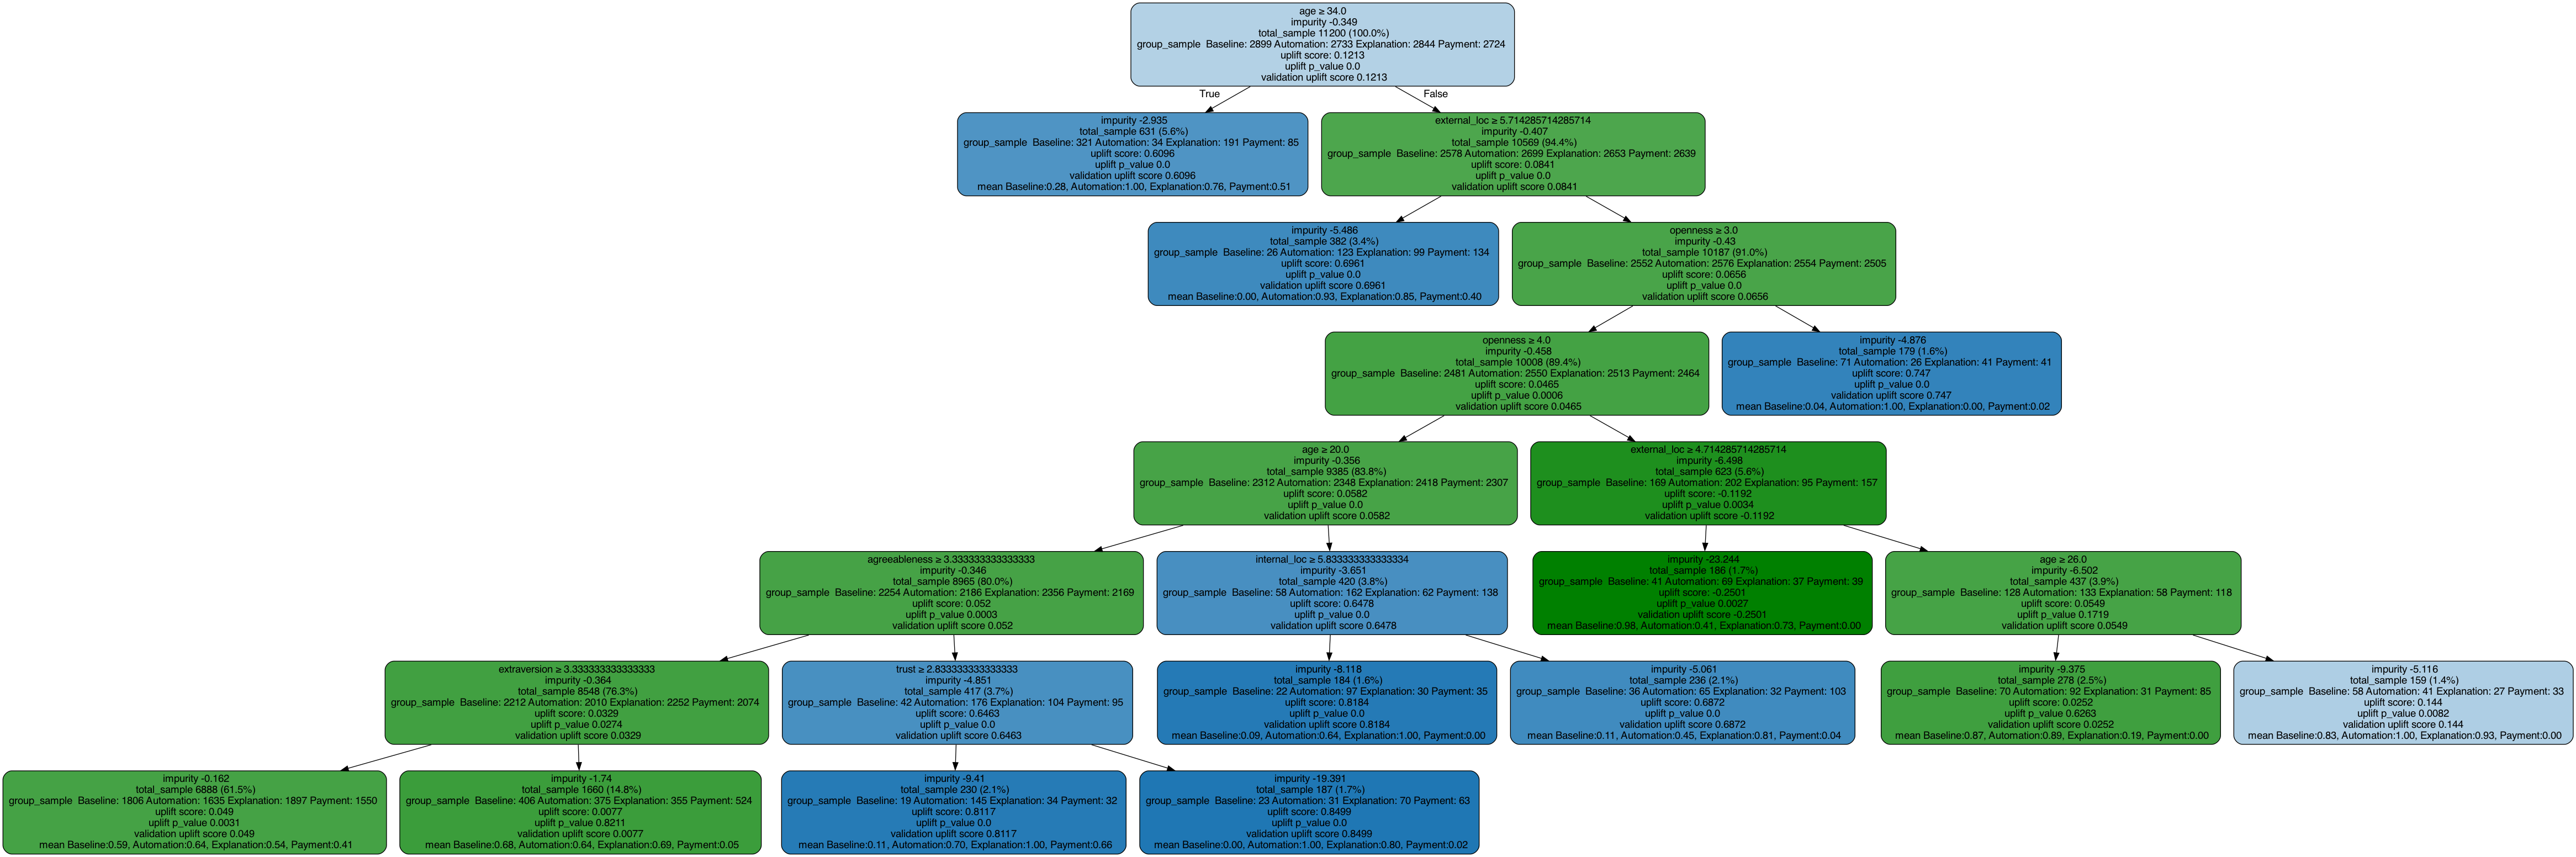

In [57]:
graph = uplift_tree_plot(uplift_tree_opt.fitted_uplift_tree,covariates)
Image(graph.create_png())

### Model Results

Heterogeneous treatment effects:

In [ ]:
result_opt

Average treatment effects

In [59]:
treat_means_opt = result_opt.mean()
treat_means_opt

Automation     0.119395
Explanation    0.052863
Payment       -0.257175
dtype: float64

Treatment effects distributions

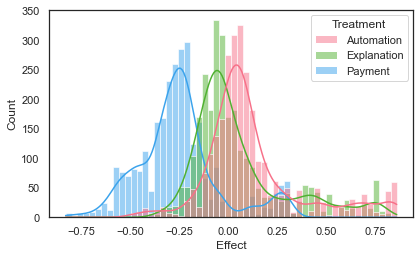

In [100]:
result_opt_melt = result_opt.melt(var_name='Treatment', value_name='Effect')
plt.figure(figsize=(6, 3.75))
sns.histplot(data=result_opt_melt, x='Effect', kde=True, hue='Treatment', palette='husl')
plt.tight_layout()

In [61]:
best_treatment = np.where((result_opt < 0).all(axis=1),
                           'control',
                           result_opt.idxmax(axis=1))

actual_is_best = np.where(df_test['treat_string'] == best_treatment, 1, 0)
actual_is_control = np.where(df_test['treat_string'] == 'Baseline', 1, 0)


synthetic = (actual_is_best == 1) | (actual_is_control == 1)
synth = result_opt[synthetic]

auuc_metrics = (synth.assign(is_treated = 1 - actual_is_control[synthetic],
                             delegation_bin = df_test.loc[synthetic, 'delegation_bin'].values,
                             uplift_tree = synth.max(axis=1))
                     .drop(columns=list(uplift_model_opt.classes_[1:])))


auuc = auuc_score(auuc_metrics, outcome_col='delegation_bin', treatment_col='is_treated')

auuc

uplift_tree    0.976987
Random         0.496055
dtype: float64

Uplift Curve

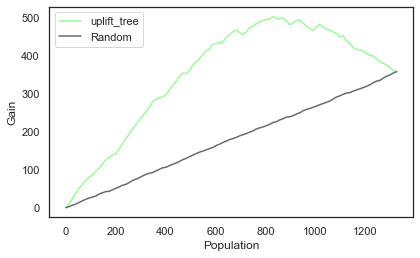

In [106]:
palette = ['palegreen', 'dimgray']
sns.set_palette(palette)
plot_gain(auuc_metrics, outcome_col='delegation_bin', treatment_col='is_treated', figsize=(6, 3.75))
plt.tight_layout()

In [78]:
new_feature_names = {
    'female': 'Female',
    'stem': 'STEM',
    'age': 'Age', 
    'extraversion': 'Extraversion', 
    'agreeableness': 'Agreeableness', 
    'conscientiousness': 'Conscientiousness',
    'neuroticism': 'Neuroticism', 
    'openness': 'Openness', 
    'internal_loc': 'LoC Internal', 
    'external_loc': 'LoC External',
    'trust': 'Generalized Trust',
    'perception': 'Perception',
    'business_econ': 'Business & Economics'
}


Feature Importances

In [84]:
df_importances = pd.DataFrame({'Importance': uplift_model_opt.feature_importances_, 'feat': covariates})
df_importances['Feature'] = df_importances['feat'].map(new_feature_names)
df_importances

,Importance,feat,Feature
0,0.040872,female,Female
1,0.014792,stem,STEM
2,0.018598,business_econ,Business & Economics
3,0.170507,age,Age
4,0.076350,extraversion,Extraversion
5,0.092756,agreeableness,Agreeableness
6,0.060596,conscientiousness,Conscientiousness
7,0.084730,neuroticism,Neuroticism
8,0.142741,openness,Openness
9,0.049270,internal_loc,LoC Internal


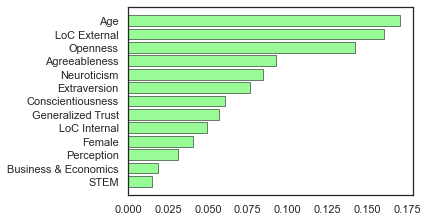

In [108]:
df_importances = df_importances.sort_values('Importance', ascending=True)

plt.figure(figsize=(6, 3.25))
plt.barh(range(len(df_importances)), df_importances['Importance'], color='palegreen',
         edgecolor='black', linewidth=0.5)
plt.yticks(range(len(df_importances)), df_importances['Feature'])
plt.tight_layout()